In [154]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
#s = json.loads(open('/Users/bhagwatsinghbisht/Downloads/fbb_matplotlibrc.json'))
#pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [155]:
nrg = gp.GeoDataFrame.from_csv("/Users/bhagwatsinghbisht/Downloads/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


In [156]:
bsize = gp.GeoDataFrame.from_file("/Users/bhagwatsinghbisht/Downloads/Manhattan/MNMapPLUTO.shp")
print bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x143b08550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1372be510>]], dtype=object)

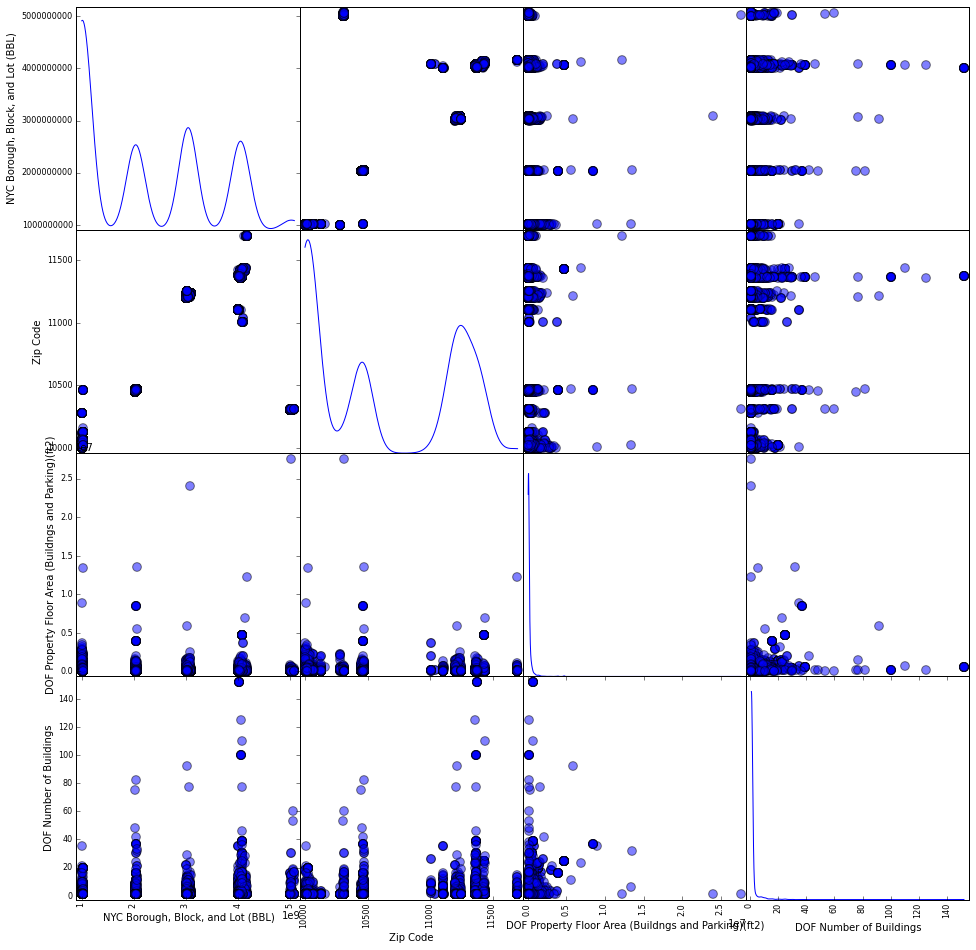

In [157]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

In [158]:
#E = ~np.isnan(nrg['Site EUI(kBtu/ft2)'])  ## energy
type(bsize)
    


geopandas.geodataframe.GeoDataFrame

In [159]:
nrg['Energy']= nrg['Site EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
nrg['Area'] = nrg['Reported Property Floor Area (Building(s)) (ft²)'].convert_objects(convert_numeric=True)
    

In [160]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']

In [161]:
bblnrgdata = pd.merge(nrg,bsize,on='BBL')

In [162]:
bblnrgdata['totalE'] = bblnrgdata['Energy'] * bblnrgdata['Area']

In [163]:
bblnrgcut = bblnrgdata[(bblnrgdata['totalE']>=1000)&(bblnrgdata['totalE']<1e+10)
                  & (bblnrgdata['UnitsTotal']>=1)&(bblnrgdata['UnitsTotal']<1000)] ## removing the outlier

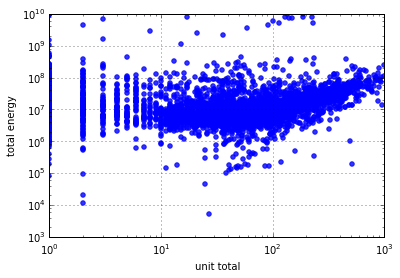

In [164]:
bblnrgcut.plot(kind='scatter', x='UnitsTotal', y='totalE', color='b', alpha=0.8, loglog=True)
pl.xlim([1, 1000])
pl.ylim([1000, 1e10])
pl.xlabel('unit total')
pl.ylabel('total energy')
pl.grid()
pl.legend()

In [166]:
import statsmodels.api as smf    # DOING FIRST FOR TOTAL E VS THE total unit 
import statsmodels.formula.api as sm
X = smf.add_constant(np.log10(bblnrgcut['UnitsTotal']))
Y = np.log10(bblnrgcut['totalE'])
model = sm.OLS(Y, X, missing='drop')#.fit() # ignores entires where x or y is NaN
fit = model.fit()
fit.summary()
#return fit.params[1], fit.params[0], fit # could also return stderr in each via fit.bse

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 totalE   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     56.32
Date:                Wed, 14 Oct 2015   Prob (F-statistic):           7.26e-14
Time:                        15:11:24   Log-Likelihood:                -3378.5
No. Observations:                4956   AIC:                             6761.
Df Residuals:                    4954   BIC:                             6774.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.9143      0.018    387.562      0.000         6.879     6.949
UnitsTotal     0.0748      0.010      7.505      0.000         0.055     0.094
==============================================================================
Omnibus:                     1218.354   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10046.460
Skew:                           0.941   Prob(JB):                         0.00
Kurtosis:                       9.716   Cond. No.                         6.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

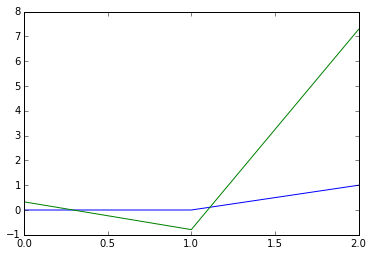

In [195]:
A = np.polyfit(Y,X,2)    ##fitting a second degree curve to it: ax^2+bx+c.
plt.xlabel='Total units'
plt.ylabel='Energy'
plt.legend()
plt.plot(A, label='X')

In [189]:
import statsmodels.api as smf  ## DOING REVERSE
import statsmodels.formula.api as sm
X = smf.add_constant(np.log10(bblnrgcut['totalE']))
Y = np.log10(bblnrgcut['UnitsTotal'])    #(bblnrgcut['totalE'])
model = sm.OLS(Y, X, missing='drop')#.fit() # ignores entires where x or y is NaN
fit = model.fit()
fit.summary()
#return fit.params[1], fit.params[0], fit # could also return stderr in each via fit.bse

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     56.32
Date:                Wed, 14 Oct 2015   Prob (F-statistic):           7.26e-14
Time:                        15:36:01   Log-Likelihood:                -5105.9
No. Observations:                4956   AIC:                         1.022e+04
Df Residuals:                    4954   BIC:                         1.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5971      0.141      4.228      0.000         0.320     0.874
totalE         0.1502      0.020      7.505      0.000         0.111     0.189
==============================================================================
Omnibus:                      795.078   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1226.734
Skew:                          -1.157   Prob(JB):                    4.15e-267
Kurtosis:                       3.763   Cond. No.                         106.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TypeError: 'str' object is not callable

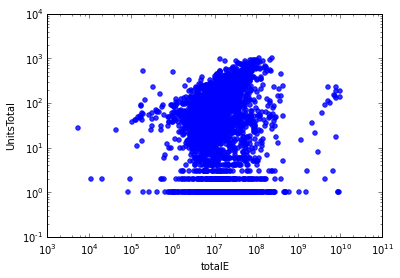

In [190]:
bblnrgcut.plot(kind='scatter', x='totalE', y='UnitsTotal', color='b', alpha=0.8, loglog=True)
#pl.xlim([1, 1000])
#pl.ylim([1000, 1e10])
pl.xlabel('unit total')
pl.ylabel('total energy')
pl.grid()
pl.legend()

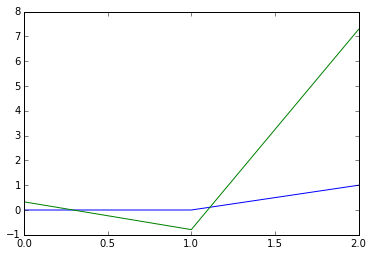

In [192]:
A = np.polyfit(Y,X,2)
plt.xlabel='Energy'
plt.ylabel='Total Units'
plt.legend()
plt.plot(A)

## observation  : Graph of energy vs units is better. Likelihood test not possible since the degree of freedom is different

array([[  3.01784957e-16,   3.29857541e-01],
       [ -3.60987113e-15,  -7.90609797e-01],
       [  1.00000000e+00,   7.28993951e+00]])